In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url

In [2]:
dataset_url = "http://files.fast.ai/data/cifar10.tgz"
download_url(dataset_url, '.')

with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
        
data_dir = './data/cifar10'

In [3]:
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test', 'labels.txt']
['airplane', 'frog', 'horse', 'bird', 'dog', 'cat', 'ship', 'truck', 'deer', 'automobile']


In [4]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

In [5]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [6]:
train_trnsfrms=tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats)])
valid_trnsfrms=tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [7]:
train_ds = ImageFolder(data_dir+'/train', train_trnsfrms)
valid_ds = ImageFolder(data_dir+'/test', valid_trnsfrms)

In [8]:
from torch.utils.data import DataLoader
batch_size=256

In [9]:
train_dl=DataLoader(train_ds, batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_dl=DataLoader(valid_ds, batch_size, shuffle=False, num_workers=8, pin_memory=True)

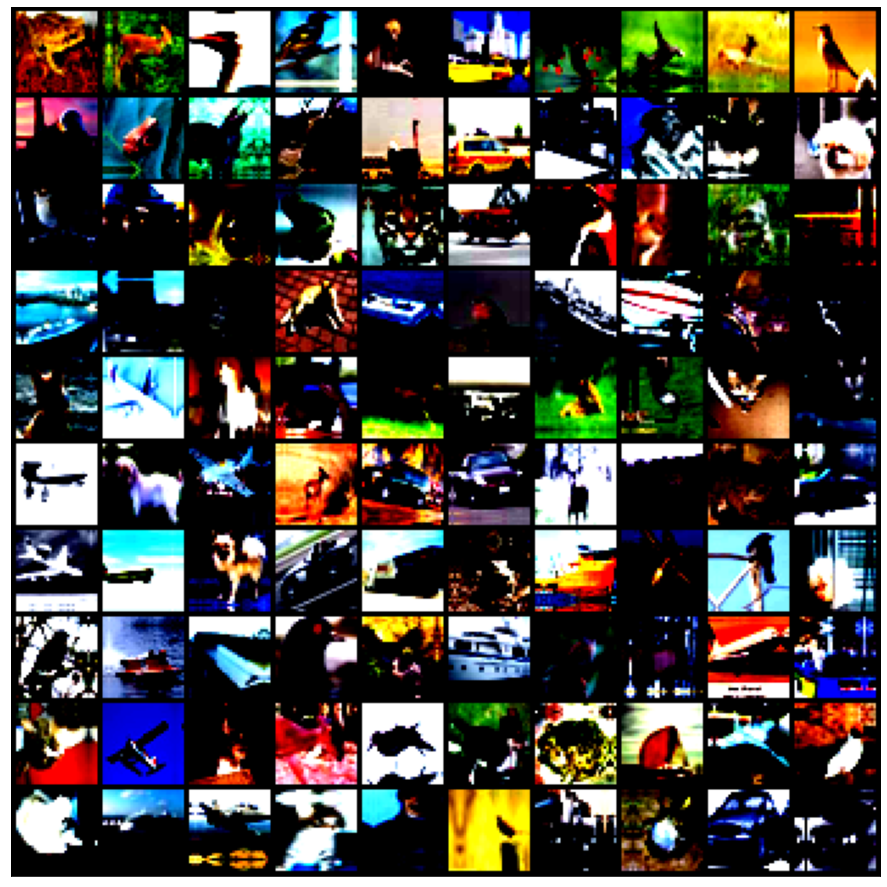

In [10]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:100], 10).permute(1, 2, 0))
        break
show_batch(train_dl)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out + x)
simple_resnet = SimpleResidualBlock()

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break

torch.Size([256, 3, 32, 32])


In [13]:
def conv_2d(ni, no, stride=1, ks=3):
    return nn.Conv2d(in_channels=ni, out_channels=no, kernel_size=ks, 
                     stride=stride, padding=ks//2, bias=False)

def bn_relu_conv(ni, no):
    return nn.Sequential(nn.BatchNorm2d(ni), nn.ReLU(inplace=True), conv_2d(ni, no))

class ResidualBlock(nn.Module):
    def __init__(self, ni, no, stride=1):
        super().__init__()
        self.bn=nn.BatchNorm2d(ni)
        self.conv1=conv_2d(ni, no, stride)
        self.conv2=bn_relu_conv(no, no)
        self.shortcut=lambda x: x
        if(ni!=no):
            self.shortcut=conv_2d(ni, no, stride, ks=1) 
            
    def forward(self, x):
        x=F.relu(self.bn(x), inplace=2)
        r=self.shortcut(x)
        x=self.conv1(x)
        x=self.conv2(x)*0.2
        return x.add_(r)

In [14]:
def make_group(N, ni, nf, stride):
    start = ResidualBlock(ni, nf, stride)
    rest = [ResidualBlock(nf, nf) for j in range(1, N)]
    return [start] + rest

class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

class WideResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=16):
        super().__init__()      
        layers = [conv_2d(3, n_start)]
        n_channels = [n_start]
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            layers += make_group(N, n_channels[i], 
                                 n_channels[i+1], stride)
            
            
        layers += [nn.BatchNorm2d(n_channels[3]), 
                   nn.ReLU(inplace=True), 
                   nn.AdaptiveAvgPool2d(1), 
                   Flatten(), 
                   nn.Linear(n_channels[3], n_classes)]
        
        self.features = nn.Sequential(*layers)
        
    def forward(self, x): return self.features(x)
    
def wrn_22(): 
    return WideResNet(n_groups=3, N=3, n_classes=10, k=6)

In [15]:
model=wrn_22()

In [16]:
model

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ResidualBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResidualBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [17]:
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy

In [18]:
data = DataBunch.create(train_ds, valid_ds, bs=batch_size, path='./data/cifar10')
learner = Learner(data, model, loss_func=F.cross_entropy, metrics=[accuracy])
learner.clip = 0.1

In [19]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


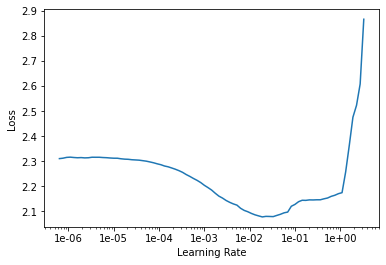

In [20]:
learner.recorder.plot()

In [21]:
learner.fit_one_cycle(10, 5e-3, wd=1e-4)


epoch,train_loss,valid_loss,accuracy,time
0,1.278976,1.161439,0.586800,01:00
1,0.929688,1.280496,0.606700,00:59
2,0.733843,0.973071,0.680900,00:59
3,0.585583,0.849937,0.722000,00:59
4,0.475508,0.566930,0.811300,00:59
5,0.381390,0.530814,0.831600,00:59
6,0.306659,0.334300,0.886800,00:59
7,0.223367,0.288317,0.904100,00:59
8,0.170581,0.261454,0.915100,00:59
9,0.144659,0.260626,0.916800,00:59


In [22]:
learner.fit_one_cycle(10, 1e-3, wd=1e-4)


epoch,train_loss,valid_loss,accuracy,time
0,0.138901,0.262875,0.915000,00:59
1,0.151060,0.281824,0.908100,00:59
2,0.155911,0.288522,0.906600,00:59
3,0.142366,0.291809,0.909400,00:59
4,0.129663,0.304818,0.906600,00:59
5,0.100574,0.291578,0.914300,00:59
6,0.089836,0.274989,0.918400,00:59
7,0.067665,0.286494,0.919600,00:59
8,0.056843,0.281997,0.922300,00:59
9,0.051578,0.279912,0.922000,00:59


In [23]:
learner.fit_one_cycle(5, 1e-4, wd=1e-4)


epoch,train_loss,valid_loss,accuracy,time
0,0.050571,0.282809,0.922100,00:59
1,0.052658,0.286816,0.920400,00:59
2,0.046881,0.288465,0.920700,00:59
3,0.047095,0.291136,0.921900,00:59
4,0.046871,0.292231,0.922400,00:59


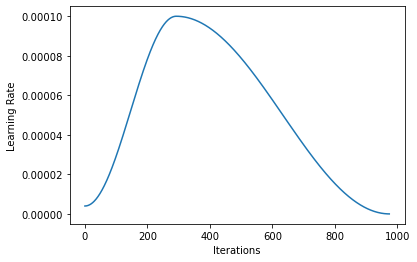

In [24]:
learner.recorder.plot_lr()


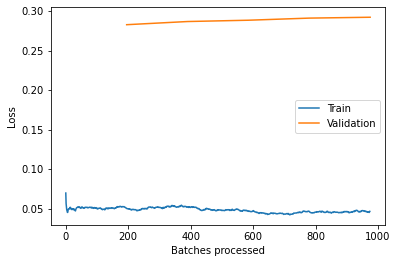

In [25]:
learner.recorder.plot_losses()


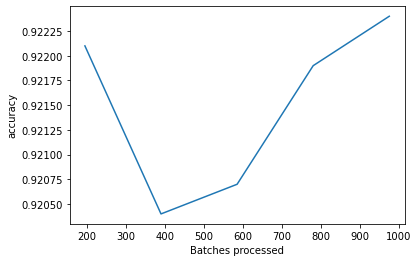

In [26]:
learner.recorder.plot_metrics()

In [27]:
torch.save(model.state_dict(), 'cifar10-wrn22.pth')
